In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

# Extracting spectra using implicit filter
---

This notebook shows how to extract spectra using implict filter and how to process them
As an example FESOM filter will be used, but the process is the same for all types of meshes

In [4]:
from implicit_filter import IconFilter

filter = IconFilter()
filter.prepare_from_file("/scratch/b/b382615/filters/implicit_filter_ICON_grid2d_test.nc", mask=True, gpu=True)

### Saving auxiliary arrays to file is supported as well

In [18]:
filter.save_to_file("../icon_cash")

### Load it later 

In [5]:
filter = IconFilter.load_from_file("../icon_cash.npz")

### Extracting spectra
---

To extract spectra we must first defined scales that are of interest.
They should be not smaller than the resolution of the mesh.
They can be larger than mesh size,
but one must be carefull when going far beyond the mesh size, as the results might be incorrect.

In [7]:
import xarray as xr

data = xr.open_dataset("/scratch/b/b382615/filters/implicit_filter_ICON_test.nc")

ux = data['u'].values[0, :]
vy = data['v'].values[0, :]

In [8]:
grid2d = xr.open_dataset("/scratch/b/b382615/filters/implicit_filter_ICON_grid2d_test.nc")
xcoord = grid2d["vlon"].values * 180.0 / np.pi
ycoord = grid2d["vlat"].values * 180.0 / np.pi
tri = grid2d["vertex_of_cell"].values.T.astype(int) - 1

In case of FESOM and ICON velocities are by default on mesh elements (triangles).
To use implicit filter they need to be interpolated to mesh modes.
There's ofter already interpolated velocited available with name `unod` and `vnod`

In [9]:
from implicit_filter import transform_velocity_to_nodes

uxn, vyn = transform_velocity_to_nodes(ux, vy, filter) # This function based on the mesh will interpolate velocity to nodes

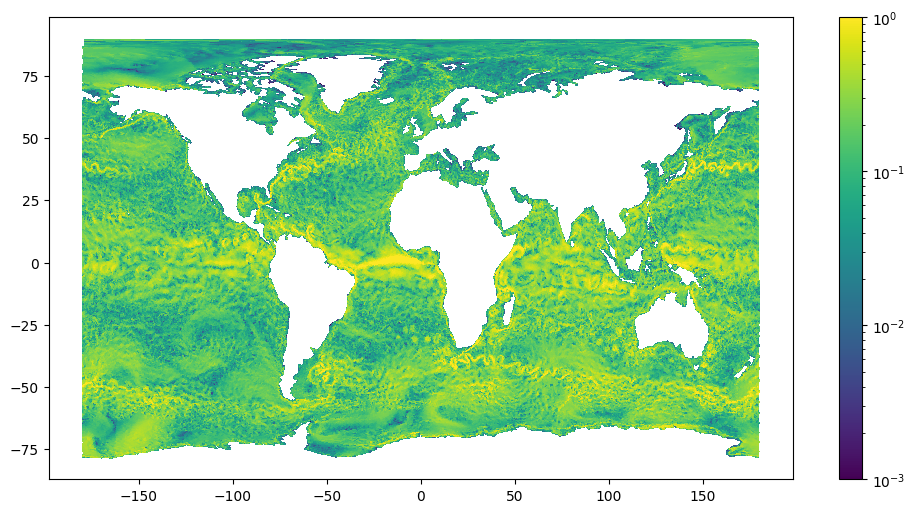

In [10]:
ok =(xcoord[tri].max(axis=1)-xcoord[tri].min(axis=1))<10 
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri[ok, :])

plt.tripcolor(triang, np.sqrt(np.square(uxn) + np.square(vyn)), norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e-0))
plt.colorbar()

In [7]:
ttu, ttv = filter.compute_velocity(1, 2 * math.pi / 1000., uxn, vyn)

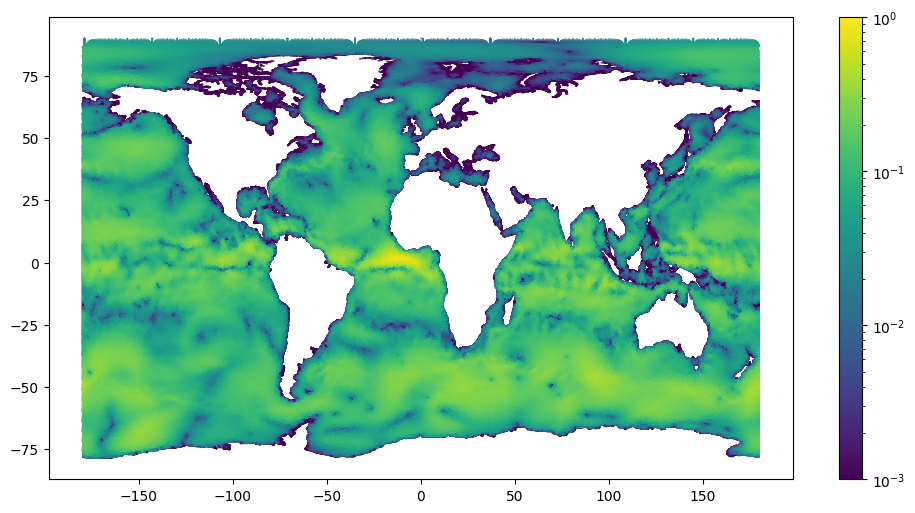

In [9]:
ok =(xcoord[tri].max(axis=1)-xcoord[tri].min(axis=1))<10 
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri[ok, :])

plt.scatter(xcoord, ycoord, c=np.sqrt(np.square(ttu) + np.square(ttv)), norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e-0), s=0.1)
plt.colorbar()

Once data is loaded we can just used built-in function to compute cumulative spectra.

The default and recommended way is to use highpass filters as they can capture steeper spectra.
We also suggest using 1st order filter, as it's computationally efficient.
If spectra are too steep to be captured by highpass 1st order filter, then one can use second order filter.
However, it's very demanding, and it's recommended to be used only on GPU.

In [6]:
Kc = np.logspace(1, 3, 30) # Mesh resolution is approx 100 km
Kc = 2 * math.pi / Kc

In [14]:
spectra = filter.compute_spectra_velocity(1, Kc, uxn, vyn)

The cumulative spectra are computed from high to low scales

Text(0, 0.5, '$ \\bar E $')

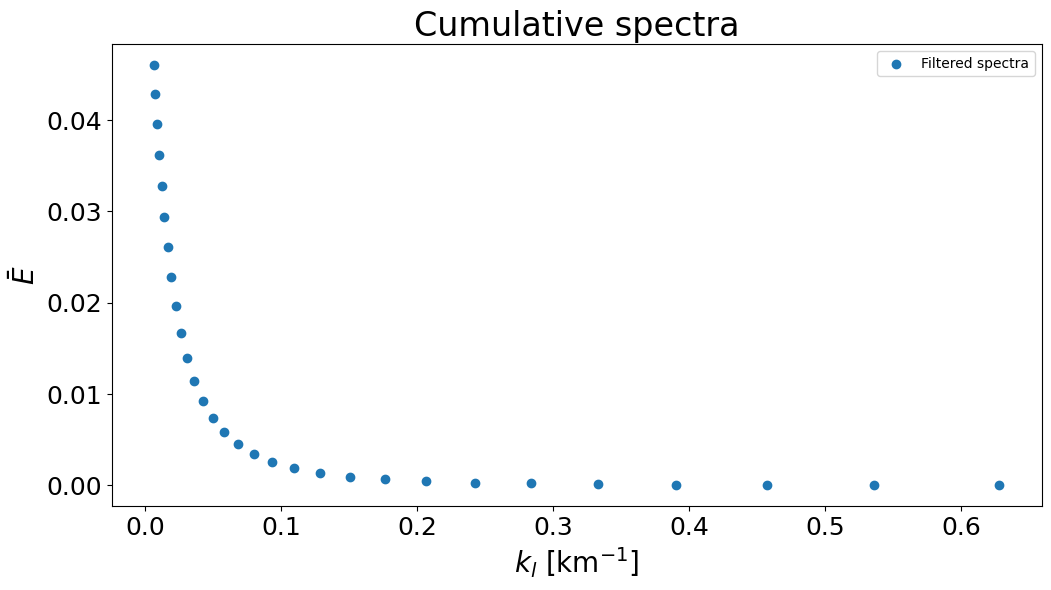

In [15]:
# Removing the first element as spectra also contains value for unfiltered data on position 0
plt.scatter(Kc, spectra[1:], label="Filtered spectra")
plt.title("Cumulative spectra", fontsize=24)
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$k_l$ [km$^{-1}$]", fontsize=20)
plt.ylabel(r"$ \bar E $", fontsize=20)

Cumulative spectra can be used to get other kinds of spectra

In [16]:
k = np.insert(Kc, 0, Kc[0])
r = np.insert(2*math.pi/Kc, 0, 0)
dr = r[1:]-r[0:-1]
dk = k[1:] - k[0:-1]
kmid = np.sqrt(k[0:-1] * k[1:])
rmid = np.sqrt(r[0:-1] * r[1:])
de_high = spectra[1:] - spectra[0:-1]

### Wavelength spectra

Text(0, 0.5, '$\\partial \\bar E / \\partial k_l $ [$ \\frac{m^3}{s^2} $]')

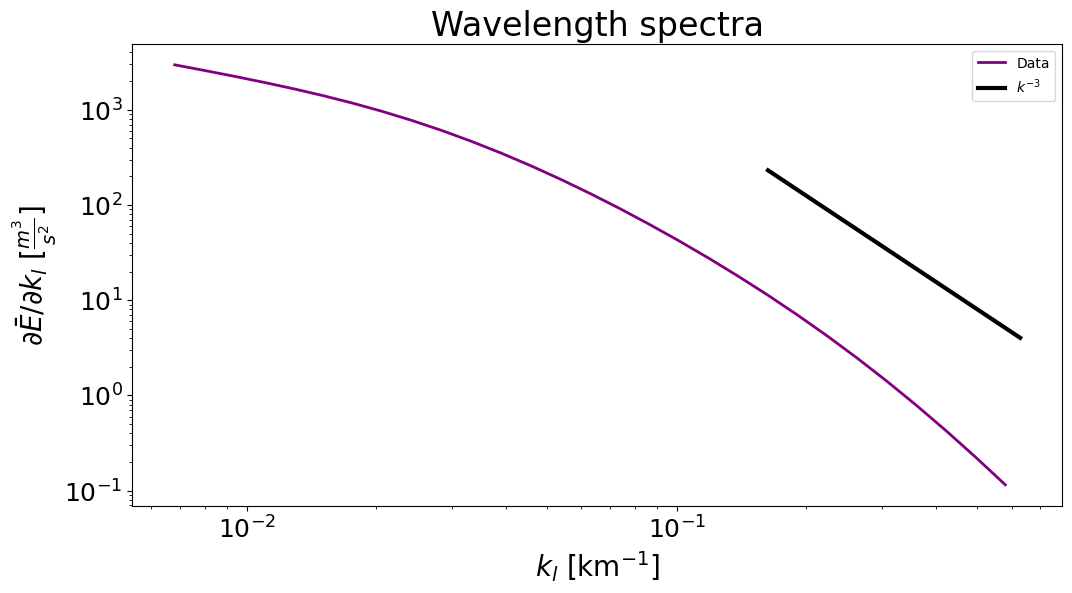

In [17]:
plt.plot(kmid[1:], (-de_high[1:] / dk[1:]) * 1000, label=r"Data", color='purple', linestyle='solid', linewidth=2)
plt.plot(kmid[0:10], kmid[0:10]**(-3) / 1e0, color='black', linestyle='solid', linewidth=3, label=r"$k^{-3}$")
plt.title("Wavelength spectra", fontsize=24)
plt.xscale("log")
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")
plt.xlabel(r"$k_l$ [km$^{-1}$]", fontsize=20)
plt.ylabel(r"$\partial \bar E / \partial k_l $ [$ \frac{m^3}{s^2} $]", fontsize=20)

### Epsilon spectra

Text(0, 0.5, '$\\partial \\bar E / \\partial r $')

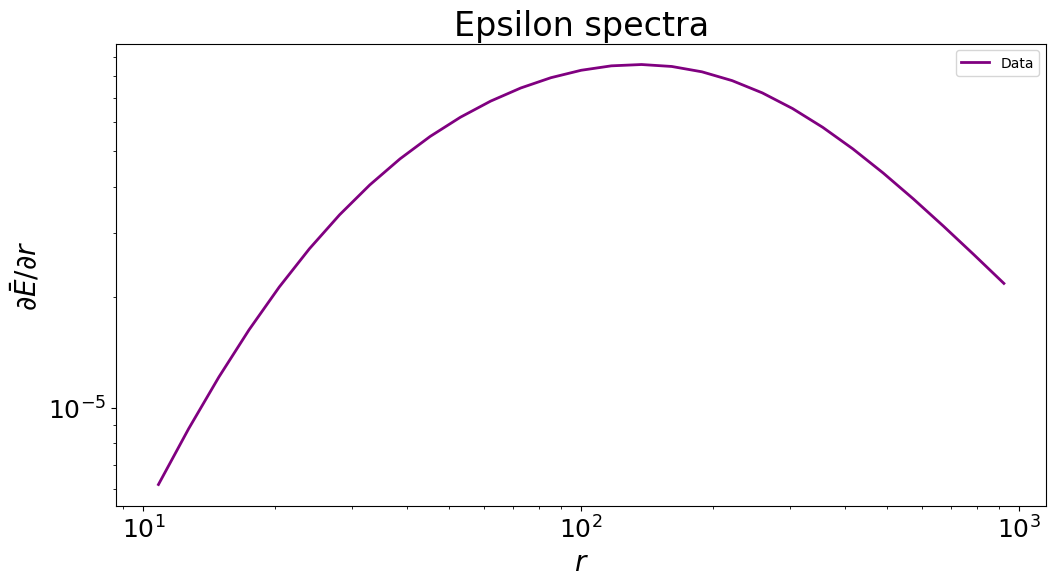

In [18]:
plt.plot(rmid[1:], de_high[1:] / dr[1:], label=r"Data", color='purple', linestyle='solid', linewidth=2)
plt.title("Epsilon spectra", fontsize=24)
plt.xscale("log")
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")
plt.xlabel(r"$r$", fontsize=20)
plt.ylabel(r"$\partial \bar E / \partial r $", fontsize=20)

### Mean energy spectra

Text(0, 0.5, '$\\partial \\bar E^2 / \\partial l $')

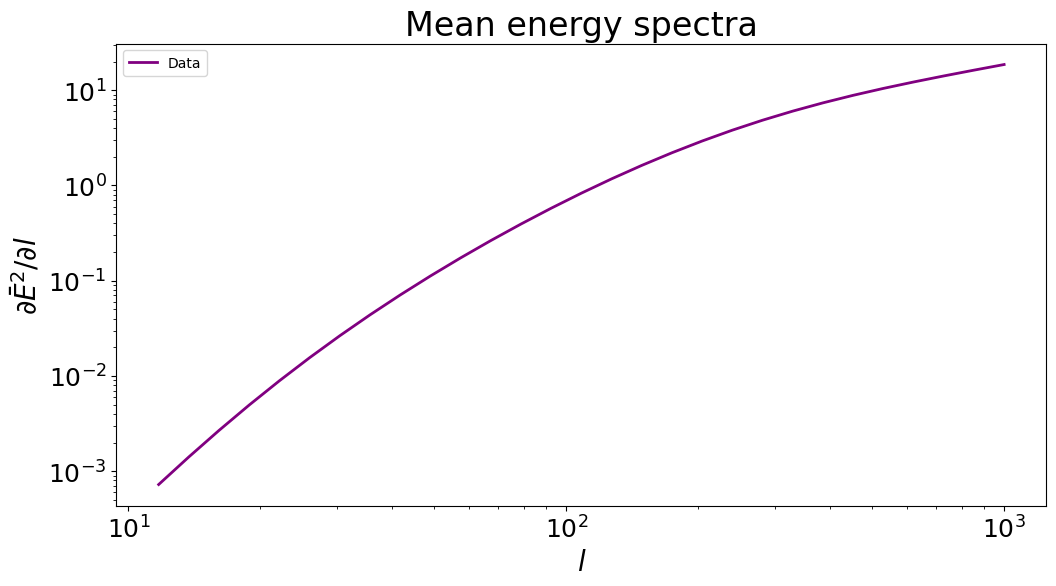

In [19]:
plt.plot(2*math.pi/Kc[1:], (rmid[1:]**2) * de_high[1:] / dr[1:], label=r"Data", color='purple', linestyle='solid', linewidth=2)
plt.title("Mean energy spectra", fontsize=24)
plt.xscale("log")
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")
plt.xlabel(r"$l$", fontsize=20)
plt.ylabel(r"$\partial \bar E^2 / \partial l $", fontsize=20)